# 初始化

In [23]:
# 基础库
import os
import time
import json
import math
import random
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import rich
from rich.console import Console
from rich.theme import Theme
from rich.text import Text
from rich.panel import Panel
from rich.table import Table
from tqdm import tqdm

# 自然语言处理相关库
import re
import jieba
from gensim.models import Word2Vec
from gensim import corpora, models

import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

# 机器学习相关库
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold

# 深度学习相关库
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset

# 项目路径设置
try:
    PROJECT_ROOT = Path("C:/Users/ShangshangZhang/Desktop/DLC/DataFountain_IndustrialIERE")
except NameError:
    PROJECT_ROOT = Path(os.getcwd()).parent.parent

# 全局参数
config = {
    # 基本参数
    "console_theme":{
        "info": "cyan",
        "title": "bold italic red",
        "train": "bold blue",
        "eval": "bold green",
        "warn": "bold yellow",
    },
    "pd_set_option_max_colwidth": None,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),

    # 模型参数
    "epochs": 50,
    "n_splits": 5,
    "batch_size": 8,
    "max_len": 512,
    "val_size": 0.2,
    "random_seed": 42,
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "use_extra_data": False,

    # 文件参数
    "path_pretrain_model" :  "C:/Users/ShangshangZhang/Desktop/DLC/Pretrain_model/hfl_chinese_roberta_wwm_ext",
    "path_data_train_raw" : str(PROJECT_ROOT / "data/raw/train.json"),
    "path_data_train_other_raw" : str(PROJECT_ROOT / "data/raw/train_other.json"),
    "path_data_test_raw" : str(PROJECT_ROOT / "data/raw/evalA.json"),
    
    "path_submission" : str(PROJECT_ROOT / "src_gplinker/submission" / "sub_exp01"),
    "path_model_saved": str(PROJECT_ROOT / "src_gplinker/model_saved" / "model_exp01"),
}

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(config["random_seed"])  
pd.set_option('display.max_colwidth', config["pd_set_option_max_colwidth"])
console = Console(theme=Theme(config["console_theme"]), color_system="truecolor")
warnings.filterwarnings("ignore")

# 查看token长度分布


==================== train.json 统计结果 ====================
样本总数: 1491
【文本字符数】 平均: 171.30 | 最大: 1444 | 最小: 10
【Token 数量】 平均: 168.28 | 最大: 1322 | 最小: 12
--- 覆盖比例统计 ---
max_len=128 覆盖比例: 47.95%
max_len=256 覆盖比例: 79.68%
max_len=384 覆盖比例: 93.23%
max_len=512 覆盖比例: 96.58%
max_len=640 覆盖比例: 98.19%


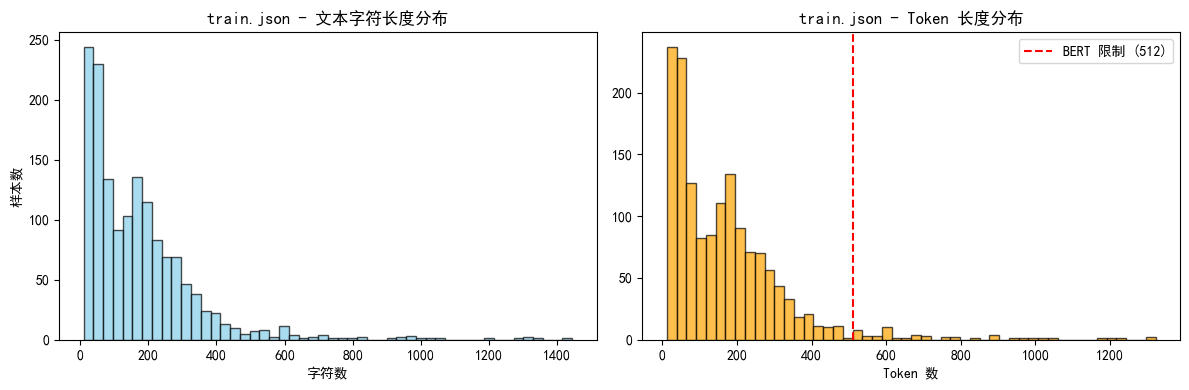


==================== train_other.json 统计结果 ====================
样本总数: 3000
【文本字符数】 平均: 67.67 | 最大: 544 | 最小: 4
【Token 数量】 平均: 67.34 | 最大: 462 | 最小: 6
--- 覆盖比例统计 ---
max_len=128 覆盖比例: 89.53%
max_len=256 覆盖比例: 98.13%
max_len=384 覆盖比例: 99.73%
max_len=512 覆盖比例: 100.00%
max_len=640 覆盖比例: 100.00%


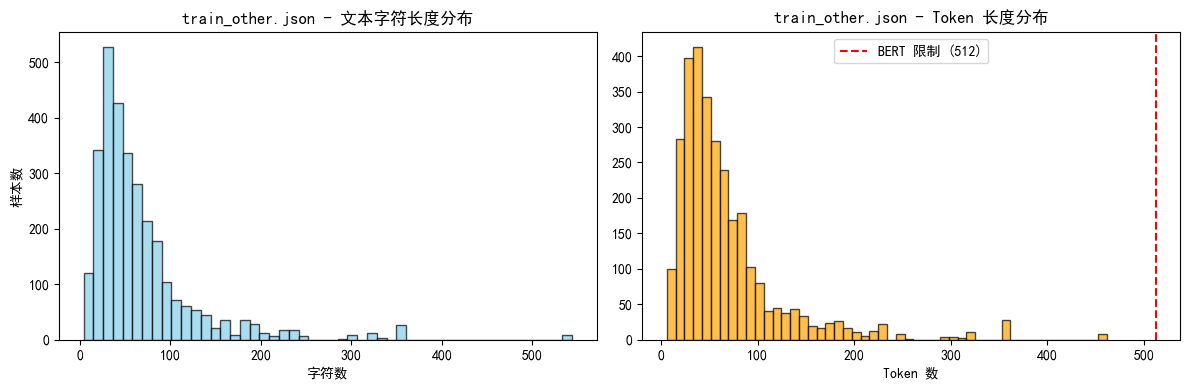


==================== evalA.json 统计结果 ====================
样本总数: 797
【文本字符数】 平均: 156.55 | 最大: 1425 | 最小: 18
【Token 数量】 平均: 154.34 | 最大: 1406 | 最小: 20
--- 覆盖比例统计 ---
max_len=128 覆盖比例: 52.82%
max_len=256 覆盖比例: 90.34%
max_len=384 覆盖比例: 95.11%
max_len=512 覆盖比例: 96.99%
max_len=640 覆盖比例: 98.12%


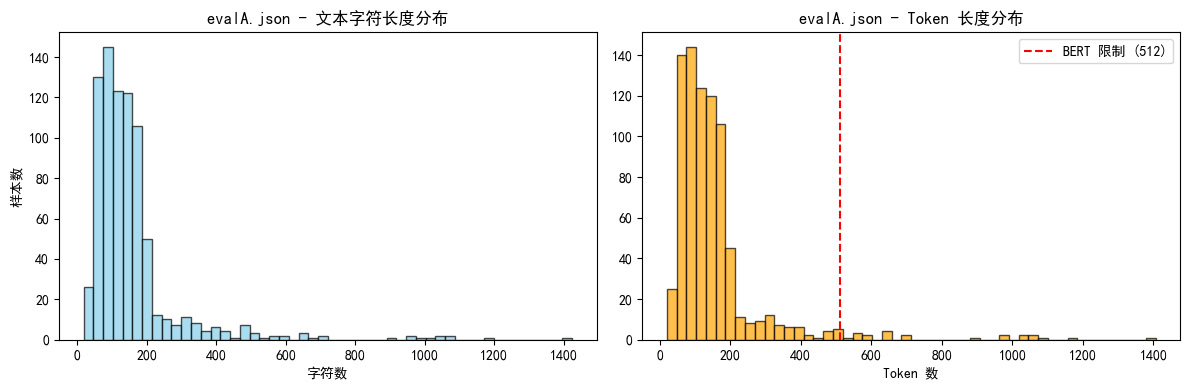

In [33]:
def analyze_data_length(file_path, tokenizer, label="Dataset"):
    """
    分析数据集的文本长度和 Token 长度分布
    :param file_path: 文件路径 (支持 list 格式 JSON 或 JSONL)
    :param tokenizer: 预训练模型的 tokenizer
    :param label: 用于图表显示的标签（如 "Train" 或 "Train_Other"）
    """
    text_lengths = []
    token_lengths = []

    # 1. 加载数据
    with open(file_path, 'r', encoding='utf-8') as f:
        try:
            # 尝试整体加载 (Standard JSON List)
            data = json.load(f)
        except json.JSONDecodeError:
            # 失败则按行加载 (JSONL)
            f.seek(0)
            data = [json.loads(line) for line in f if line.strip()]

    # 2. 统计长度
    for item in data:
        text = item.get('text', '')
        if not text: continue
        
        text_lengths.append(len(text))
        # 使用 encode 统计 token 数量
        tokens = tokenizer.encode(text, add_special_tokens=True)
        token_lengths.append(len(tokens))

    text_lens = np.array(text_lengths)
    token_lens = np.array(token_lengths)

    # 3. 打印统计信息
    print(f"\n" + "="*20 + f" {label} 统计结果 " + "="*20)
    print(f"样本总数: {len(text_lens)}")
    print(f"【文本字符数】 平均: {text_lens.mean():.2f} | 最大: {text_lens.max()} | 最小: {text_lens.min()}")
    print(f"【Token 数量】 平均: {token_lens.mean():.2f} | 最大: {token_lens.max()} | 最小: {token_lens.min()}")
    
    # 计算覆盖率
    max_lens = [128, 256, 384, 512, 640]
    print("--- 覆盖比例统计 ---")
    for ml in max_lens:
        coverage = (token_lens <= ml).mean()
        print(f"max_len={ml} 覆盖比例: {coverage*100:.2f}%")

    # 4. 可视化分布
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(text_lens, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f"{label} - 文本字符长度分布")
    plt.xlabel("字符数")
    plt.ylabel("样本数")

    plt.subplot(1, 2, 2)
    plt.hist(token_lens, bins=50, color='orange', edgecolor='black', alpha=0.7)
    plt.axvline(x=512, color='red', linestyle='--', label='BERT 限制 (512)')
    plt.title(f"{label} - Token 长度分布")
    plt.xlabel("Token 数")
    plt.legend()

    plt.tight_layout()
    plt.show()

tokenizer = BertTokenizerFast.from_pretrained(config["path_pretrain_model"])

analyze_data_length(config["path_data_train_raw"], tokenizer, label="train.json")

analyze_data_length(config["path_data_train_other_raw"], tokenizer, label="train_other.json")

analyze_data_length(config["path_data_test_raw"], tokenizer, label="evalA.json")

# 查看数据关系分布

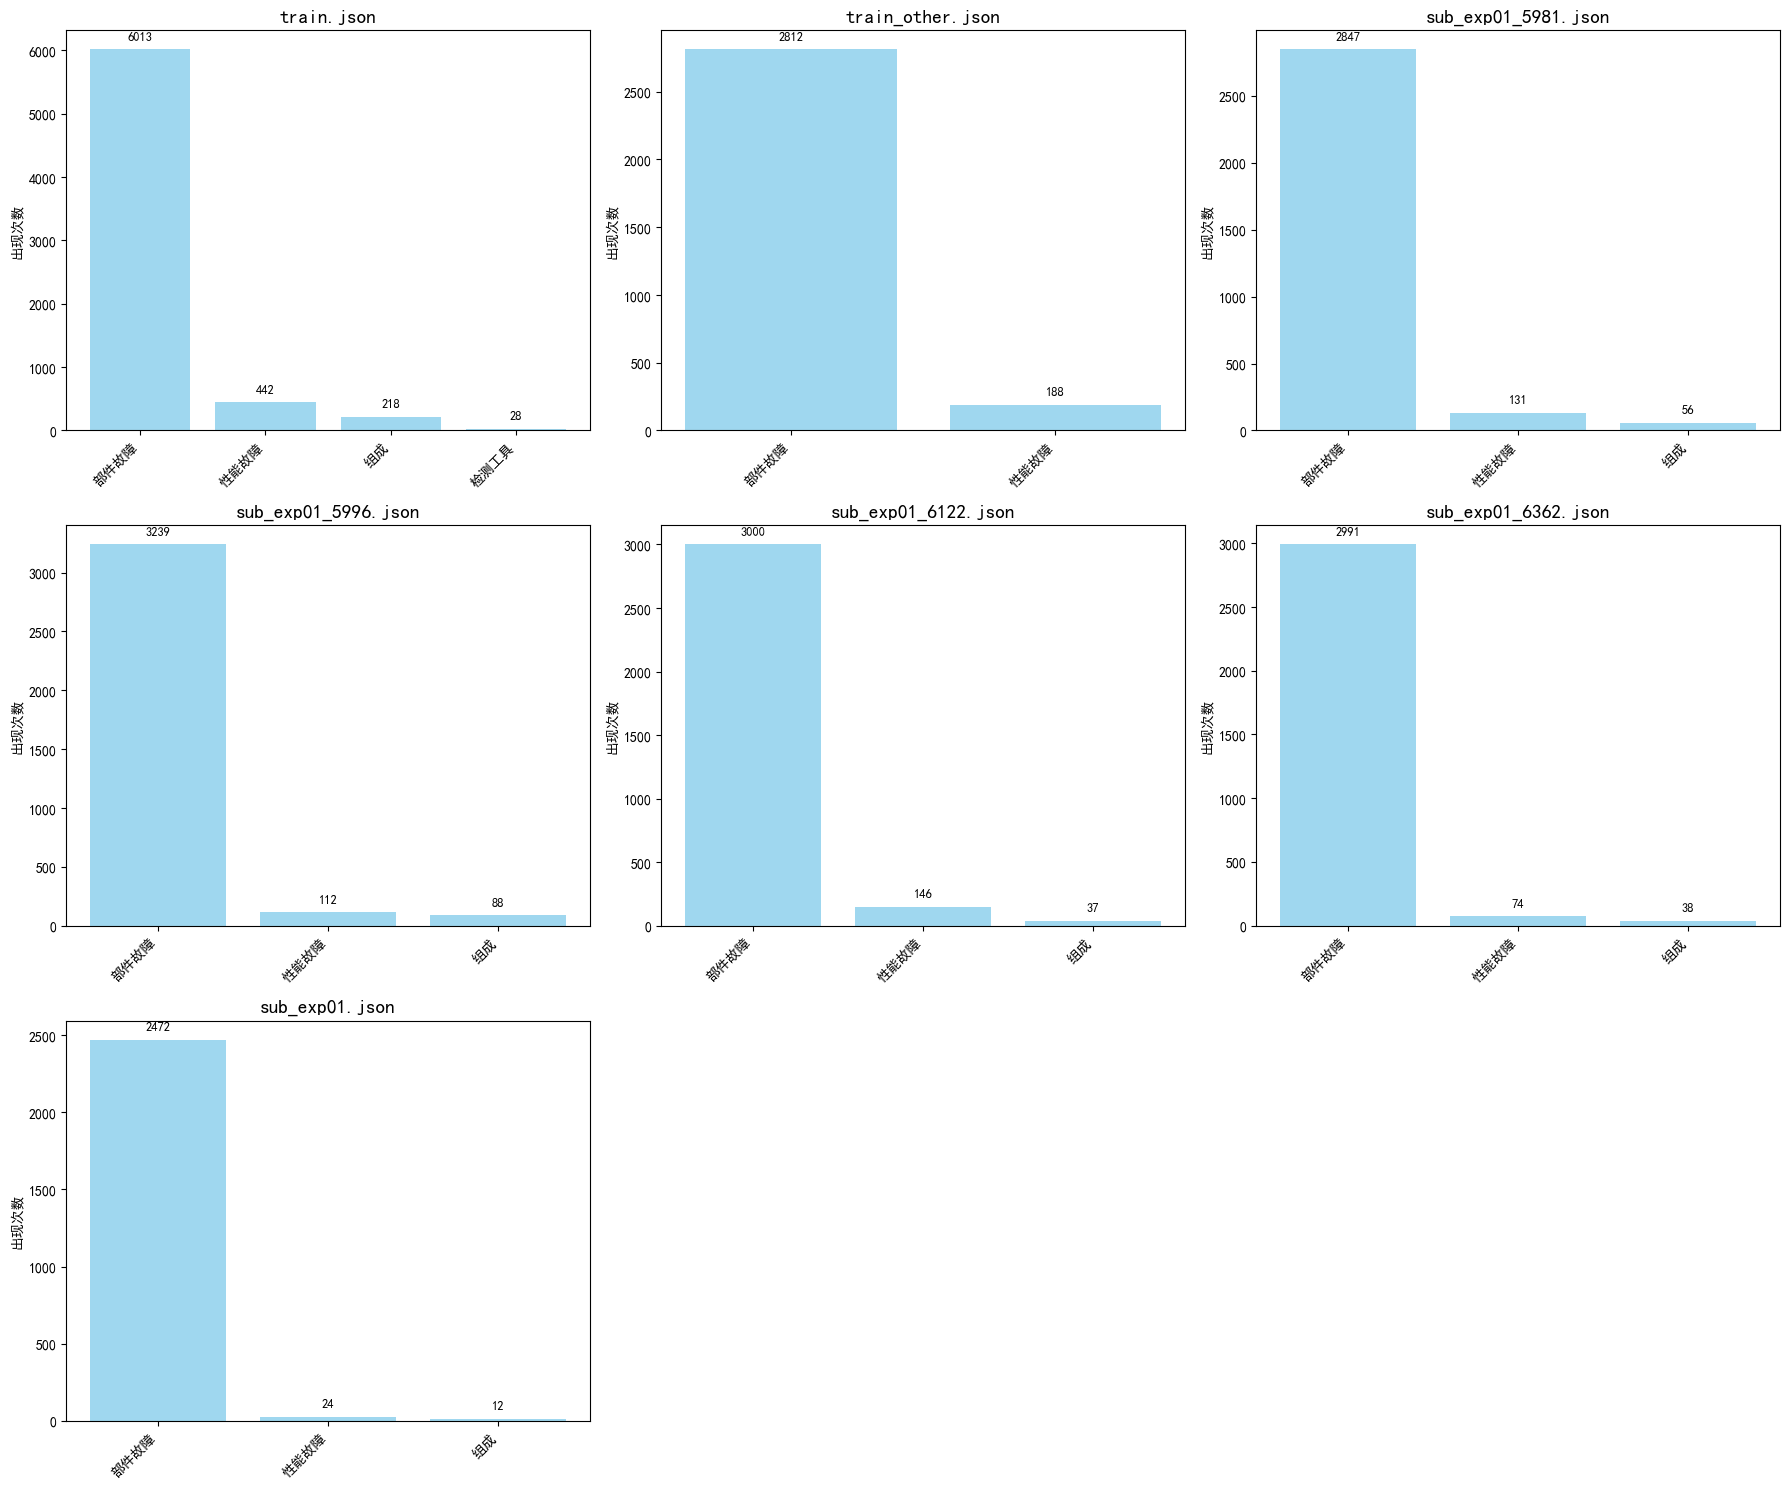

In [ ]:
def plot_multi_relation_distribution(file_paths, titles, cols=2):
    """
    在一个画布上绘制多个数据的关系分布对比图
    :param file_paths: 路径列表
    :param titles: 对应的标题列表
    :param cols: 每行显示的图表个数（默认为2）
    """
    # 1. 字体配置
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.rcParams['axes.unicode_minus'] = False

    num_plots = len(file_paths)
    rows = math.ceil(num_plots / cols)

    # 2. 创建画布
    # 根据图表数量动态调整画布大小 (宽, 高)
    plt.figure(figsize=(cols * 6, rows * 5))

    for i, (path, title) in enumerate(zip(file_paths, titles)):
        all_relations = []
        
        # 3. 读取数据
        try:
            with open(path, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if not line: continue
                    item = json.loads(line)
                    # 兼容不同格式：如果数据直接是列表，或者在 spo_list 键下
                    spos = item.get('spo_list', []) if isinstance(item, dict) else []
                    for spo in spos:
                        all_relations.append(spo['relation'])
        except Exception as e:
            print(f"读取 {path} 失败: {e}")
            continue

        if not all_relations:
            print(f"警告: {title} 未发现关系数据")
            continue

        # 4. 统计与排序
        df_counts = pd.DataFrame(Counter(all_relations).items(), 
                                 columns=['Rel', 'Count']).sort_values(by='Count', ascending=False)

        # 5. 绘制子图
        plt.subplot(rows, cols, i + 1)
        bars = plt.bar(df_counts['Rel'], df_counts['Count'], color='skyblue', alpha=0.8)
        
        # 标注数值（字体缩小一点，防止重叠）
        max_val = df_counts['Count'].max()
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + (max_val * 0.02), 
                     int(yval), ha='center', va='bottom', fontsize=9)

        plt.title(title, fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('出现次数')

    plt.tight_layout()
    plt.show()

# --- 调用方式 ---
paths = [
    config["path_data_train_raw"],
    config["path_data_train_other_raw"],
    PROJECT_ROOT / "src_gplinker/submission" / "sub_exp01_5981.json",
    PROJECT_ROOT / "src_gplinker/submission" / "sub_exp01_5996.json",
    PROJECT_ROOT / "src_gplinker/submission" / "sub_exp01_6122.json",
    PROJECT_ROOT / "src_gplinker/submission" / "sub_exp01_6362.json",
    PROJECT_ROOT / "src_gplinker/submission" / "sub_exp01.json",
]

titles = [
    "train.json",
    "train_other.json",
    "sub_exp01_5981.json",
    "sub_exp01_5996.json",
    "sub_exp01_6122.json",
    "sub_exp01_6362.json",
    "sub_exp01.json",
]

plot_multi_relation_distribution(paths, titles, cols=3)

# 查看sub样本区别

In [37]:
def load_json(file_path):
    """加载 JSON 文件，支持 list 格式或 JSONL 格式"""
    with open(file_path, 'r', encoding='utf-8') as f:
        try:
            data = json.load(f)
            if isinstance(data, list):
                return data
        except json.JSONDecodeError:
            f.seek(0)
            return [json.loads(line) for line in f if line.strip()]

def normalize_spo(spo_list):
    """
    将 spo_list 转换为可排序且唯一的集合，方便比对。
    由于 dict 是不可哈希的，我们将其转换为 tuple。
    """
    normalized = []
    for spo in spo_list:
        # 提取核心信息：主语、谓语、宾语及其位置
        h = spo['h']['name']
        h_pos = tuple(spo['h']['pos'])
        t = spo['t']['name']
        t_pos = tuple(spo['t']['pos'])
        rel = spo['relation']
        normalized.append((h, h_pos, rel, t, t_pos))
    return set(normalized)

def compare_json_files(file1_path, file2_path):
    data1 = load_json(file1_path)
    data2 = load_json(file2_path)

    # 转换为 ID 为键的字典
    dict1 = {item['ID']: item for item in data1}
    dict2 = {item['ID']: item for item in data2}

    ids1 = set(dict1.keys())
    ids2 = set(dict2.keys())

    # 1. 查找 ID 差异
    only_in_1 = ids1 - ids2
    only_in_2 = ids2 - ids1
    common_ids = ids1 & ids2

    print(f"文件1样本数: {len(ids1)}")
    print(f"文件2样本数: {len(ids2)}")
    print(f"共同 ID 数量: {len(common_ids)}")
    if only_in_1: print(f"只在文件1中的 ID: {only_in_1}")
    if only_in_2: print(f"只在文件2中的 ID: {only_in_2}")

    # 2. 对比共同 ID 的内容
    diff_samples = []
    for _id in common_ids:
        spo1 = normalize_spo(dict1[_id]['spo_list'])
        spo2 = normalize_spo(dict2[_id]['spo_list'])

        if spo1 != spo2:
            diff_samples.append({
                "ID": _id,
                "text": dict1[_id]['text'],
                "file1_only": spo1 - spo2,
                "file2_only": spo2 - spo1
            })

    print(f"\n结果统计:")
    print(f"内容完全一致的样本数: {len(common_ids) - len(diff_samples)}")
    print(f"内容存在差异的样本数: {len(diff_samples)}")

    # 3. 输出前几个不同的样本详情
    if diff_samples:
        print("\n--- 差异示例 (前3个) ---")
        for i, diff in enumerate(diff_samples[:3]):
            print(f"【示例 {i+1}】ID: {diff['ID']}")
            print(f"文本: {diff['text']}")
            if diff['file1_only']:
                print(f"  仅在文件1中存在: {diff['file1_only']}")
            if diff['file2_only']:
                print(f"  仅在文件2中存在: {diff['file2_only']}")
            print("-" * 30)

# --- 调用方式 ---
console.print("查看第一组差距", style="title")
compare_json_files(
    PROJECT_ROOT / "src_gplinker" / "submission" / "sub_exp01.json",
    PROJECT_ROOT / "src_gplinker" / "submission" / "sub_exp01_6445.json",
)

查看第一组差距

文件1样本数: 797
文件2样本数: 797
共同 ID 数量: 797

结果统计:
内容完全一致的样本数: 43
内容存在差异的样本数: 754

--- 差异示例 (前3个) ---
【示例 1】ID: AE0389
文本: 本体渗漏油现象：本体外部有油污痕迹或油珠滴落现象。器身下部地面有油渍。油位下降。处理原则：检查本体外绝缘、法兰、金属膨胀器、引线接头等处有无渗漏油现象，确定渗漏油部位。根据渗漏油及油位情况，判断缺陷的严重程度。如果渗漏油情况严重，危及设备运行安全，应立即汇报值班调控人员申请停运处理。
  仅在文件1中存在: {('器身', (25, 27), '部件故障', '油位下降', (35, 39)), ('器', (25, 26), '部件故障', '地面有油渍', (29, 34)), ('本体外部', (8, 12), '部件故障', '有油污痕迹', (12, 17)), ('器身下部地面', (25, 31), '部件故障', '地面有油渍', (29, 34)), ('本体', (8, 10), '部件故障', '油珠滴落', (18, 22)), ('器身下部地面', (25, 31), '部件故障', '有油渍。油位下降', (31, 39)), ('本体', (0, 2), '部件故障', '有油污痕迹', (12, 17)), ('器身', (25, 27), '部件故障', '有油渍。油位下降', (31, 39)), ('本体', (8, 10), '部件故障', '滴落', (20, 22)), ('器身下部', (25, 29), '部件故障', '地面有油渍', (29, 34)), ('器身', (25, 27), '部件故障', '地面有油渍', (29, 34)), ('器身下部地面', (25, 31), '部件故障', '油位下降', (35, 39)), ('器', (25, 26), '部件故障', '有油渍', (31, 34)), ('器身下部地面', (25, 31), '部件故障', '有油渍', (31, 34)), ('本体', (8, 10), '部件故障', '外部有油污痕迹', (10, 17)), ('器身下部', (25, 29), '部件故障', '有油渍', (31, 34)